In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from finta import TA
ticker = 'HDFCBANK.NS'  # Example: Apple Inc.
start_date = '2000-01-01'
end_date = '2024-12-31'

# Fetch the historical data
data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
data['change'] = ((data['Close'] - data['Open'])/data['Open'])*100
data['change_shifted'] = data['change'].shift(-1)
data['class'] = np.where(data['change_shifted'] > 0.5, 1, 0)



[*********************100%%**********************]  1 of 1 completed


In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
ohlc = pd.DataFrame()
ohlc['open'] = data['Open']
ohlc['high'] = data['High']
ohlc['low'] = data['Low']
ohlc['close'] = data['Close'] 
ohlcv = pd.DataFrame()
ohlcv['open'] = data['Open']
ohlcv['high'] = data['High']
ohlcv['low'] = data['Low']
ohlcv['close'] = data['Close'] 
ohlcv['volume'] = data['Volume']

In [12]:
bbands = TA.BBANDS(ohlc)
ema = TA.EMA(ohlc)
rsi = TA.RSI(ohlc)
# stoch = TA.STOCHF(ohlc)
macd = TA.MACD(ohlc)
atr = TA.ATR(ohlc)
vwap = TA.VWAP(ohlcv)
obv = TA.OBV(ohlcv)
tsi = TA.TSI(ohlc)
mfi = TA.MFI(ohlcv)
kc = TA.KC(ohlc)
cci = TA.CCI(ohlc)
adx = TA.ADX(ohlc)
dmi = TA.DMI(ohlc)

df = data.copy()
df = pd.concat([df,bbands,ema,rsi,macd,atr,vwap,obv,tsi,mfi,kc,cci,adx,dmi],axis=1)

In [13]:
cutoff_date = '2000-02-21'
df_cut = df[df.index >= cutoff_date]
nan_count = df_cut.isna().sum()
nan_count

Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
change             0
change_shifted     1
class              0
BB_UPPER           0
BB_MIDDLE          0
BB_LOWER           0
9 period EMA       0
14 period RSI      0
MACD               0
SIGNAL             0
14 period ATR      0
VWAP.              0
OBV               91
TSI                0
signal            11
14 period MFI      0
KC_UPPER           0
KC_LOWER           0
20 period CCI      0
14 period ADX.     0
DI+                0
DI-                0
dtype: int64

In [14]:
check = df_cut.drop('OBV' , axis=1)
check = check.drop('signal' , axis=1)
check = check.drop(check.index[-1])
check.isna().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
change            0
change_shifted    0
class             0
BB_UPPER          0
BB_MIDDLE         0
BB_LOWER          0
9 period EMA      0
14 period RSI     0
MACD              0
SIGNAL            0
14 period ATR     0
VWAP.             0
TSI               0
14 period MFI     0
KC_UPPER          0
KC_LOWER          0
20 period CCI     0
14 period ADX.    0
DI+               0
DI-               0
dtype: int64

In [15]:
from sklearn.preprocessing import StandardScaler
x = check.drop(['change_shifted' , 'class'] , axis=1)
y = check['class']  
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42) 

### CNN Model

In [16]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten


X_train_reshaped = X_train.values.reshape(-1, X_train.shape[1], 1)
X_test_reshaped = X_test.values.reshape(-1, X_test.shape[1], 1)


cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])


cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn.fit(X_train_reshaped, y_train, epochs=50, batch_size=64, validation_split=0.2)
loss, accuracy = cnn.evaluate(X_test_reshaped, y_test)
print("cnn accuracy:", accuracy)
# probabilities = model2.predict(X_test)
# print("Probabilities:\n", probabilities)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6624 - loss: 0.6520 - val_accuracy: 0.6715 - val_loss: 0.6384
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6732 - loss: 0.6319 - val_accuracy: 0.6697 - val_loss: 0.6290
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6672 - loss: 0.6296 - val_accuracy: 0.6706 - val_loss: 0.6298
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6696 - loss: 0.6313 - val_accuracy: 0.6715 - val_loss: 0.6280
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6693 - loss: 0.6308 - val_accuracy: 0.6715 - val_loss: 0.6298
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6559 - loss: 0.6452 - val_accuracy: 0.6715 - val_loss: 0.6275
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6709 - loss: 0.6294 - val_accuracy: 0.6715 - val_loss: 0.6274
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6721 - loss: 0.6296 - val_accuracy: 0.6697 - val_loss:

### MLP model

In [17]:
mlp = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])

mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = mlp.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)
loss, accuracy = mlp.evaluate(X_test, y_test)
print("MLP Accuracy:", accuracy)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5024 - loss: 0.7992 - val_accuracy: 0.6715 - val_loss: 0.6735
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6306 - loss: 0.6814 - val_accuracy: 0.6715 - val_loss: 0.6594
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6557 - loss: 0.6630 - val_accuracy: 0.6715 - val_loss: 0.6503
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6543 - loss: 0.6583 - val_accuracy: 0.6715 - val_loss: 0.6450
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6757 - loss: 0.6460 - val_accuracy: 0.6715 - val_loss: 0.6418
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6686 - loss: 0.6476 - val_accuracy: 0.6715 - val_loss: 0.6397
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6576 - loss: 0.6518 - val_accuracy: 0.6715 - val_loss: 0.6389
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6649 - loss: 0.6483 - val_accuracy: 0.6715 - val_loss:

### AUTOEncoder Model

In [18]:
ae = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])

ae.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = ae.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)
loss, accuracy = ae.evaluate(X_test, y_test)
print("AutoEncoder Accuracy:", accuracy)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5653 - loss: 0.7164 - val_accuracy: 0.6715 - val_loss: 0.6611
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6451 - loss: 0.6572 - val_accuracy: 0.6715 - val_loss: 0.6525
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6676 - loss: 0.6501 - val_accuracy: 0.6715 - val_loss: 0.6480
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6662 - loss: 0.6491 - val_accuracy: 0.6715 - val_loss: 0.6433
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6758 - loss: 0.6407 - val_accuracy: 0.6715 - val_loss: 0.6397
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6632 - loss: 0.6501 - val_accuracy: 0.6715 - val_loss: 0.6381
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6672 - loss: 0.6466 - val_accuracy: 0.6715 - val_loss: 0.6369
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6547 - loss: 0.6485 - val_accuracy: 0.6715 - val_loss:

### BiLSTM Model

In [19]:
from tensorflow.keras.layers import LSTM, Bidirectional

bilstm = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1))),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(2, activation='relu'),
    Dense(1, activation='sigmoid')
])


X_train_rnn = X_train.values.reshape(-1, X_train.shape[1], 1)
X_test_rnn = X_test.values.reshape(-1, X_test.shape[1], 1)


bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

bilstm.fit(X_train_rnn, y_train, epochs=5, batch_size=64, validation_split=0.2)
loss, accuracy = bilstm.evaluate(X_test_rnn, y_test)
print("BiLSTM Accuracy:", accuracy)

Epoch 1/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.6751 - loss: 0.6905 - val_accuracy: 0.6715 - val_loss: 0.6828
Epoch 2/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6645 - loss: 0.6809 - val_accuracy: 0.6715 - val_loss: 0.6737
Epoch 3/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6652 - loss: 0.6727 - val_accuracy: 0.6715 - val_loss: 0.6662
Epoch 4/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6793 - loss: 0.6630 - val_accuracy: 0.6715 - val_loss: 0.6598
Epoch 5/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.6694 - loss: 0.6589 - val_accuracy: 0.6715 - val_loss: 0.6545
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7048 - loss: 0.6450
BiLSTM Accuracy: 0.685761034488678


### Results

In [23]:

def evaluate_model(model, X_test, y_test , title):

    probabilities = model.predict(X_test)
    
# probabilities lower than 0.20 or higher than 0.80
    filtered_indices = (probabilities < 0.20) | (probabilities > 0.80)
    filtered_probabilities = probabilities[filtered_indices]
    filtered_actuals = y_test[filtered_indices.flatten()]
    
    
    predicted_classes = (filtered_probabilities > 0.5).astype(int)
    results = pd.DataFrame({
        'Actual': filtered_actuals,
        'Predicted': predicted_classes.flatten(),
        'Probability': filtered_probabilities.flatten()
    })
    
    
    conf_matrix = confusion_matrix(filtered_actuals, predicted_classes)
    
    
    plt.figure(figsize=(3,3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for {}'.format(title))
    plt.show()
    
    
    class_report = classification_report(filtered_actuals, predicted_classes, output_dict=True)
    report_df = pd.DataFrame(class_report).transpose()
    
    
    plt.figure(figsize=(3, 3))
    sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Classification Report')
    plt.yticks(rotation=0)
    plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


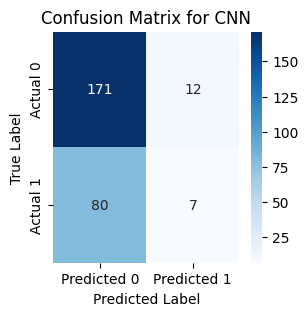

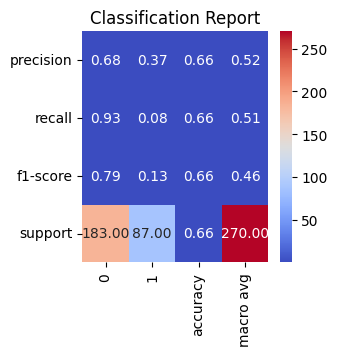

In [24]:
evaluate_model(cnn, X_test, y_test , 'CNN')